# Libraries

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torchvision.transforms import functional
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from sklearn import preprocessing
import numpy as np

import matplotlib.pyplot as plt

import os
from tqdm import tqdm

# Config

In [ ]:
num_channels = 3
linear_classifier = True # To determine if we are in self-supervised or supervised stage
num_classes  = 10

epochs = 20
lr = 0.0001
weight_decay=0.0008

# Jigsaw attributes
batch_size, n_channels, n_rows, n_cols = 32, 3, 32, 32
step = 16
patch_size = 16
grid_size = 2

# Architecture

Autoencoder model contains 3 (conv + maxpool) layers in encoder stage and 3 conv transpose layers in decoder stage. 

Latent's last 2 dimensions are 4x4. To encode all global information it would be better to define a deeper network to yield a 1x1 latent, but due to time constraints 3 encoder layers suffice.

When in supervised mode, encoder output is globalpooled and passed through an FC layer. this is the output of our model.

In [2]:
# Model

class Autoencoder(nn.Module):
    def __init__(self, linear_classifier = False, num_channels = 3):
        super(Autoencoder, self).__init__()

        self.linear_classifier = linear_classifier
        self.num_channels = num_channels

        # encoder layers
        self.enc1 = nn.Conv2d(num_channels, 512, kernel_size=3, padding=1)
        self.enc2 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.enc3 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        
        # decoder layers
        self.dec1 = nn.ConvTranspose2d(128, 128, kernel_size=2, stride=2)
        self.dec2 = nn.ConvTranspose2d(128, 256, kernel_size=2, stride=2)
        self.dec3 = nn.ConvTranspose2d(256, 512, kernel_size=2, stride=2)
        self.out = nn.Conv2d(512, num_channels, kernel_size=3, padding=1)
        
        self.bn1 = nn.BatchNorm2d(512)
        self.bn2 = nn.BatchNorm2d(256)
        self.bn3 = nn.BatchNorm2d(128)
    
        self.pool = nn.MaxPool2d(2, 2)
        self.linear = nn.Linear(128, num_classes) # For Supervised stage

    def forward(self, x):
        # encode
        x = F.relu(self.enc1(x))
        x = self.bn1(x)
        x = self.pool(x)
        x = F.relu(self.enc2(x))
        x = self.bn2(x)
        x = self.pool(x)
        x = F.relu(self.enc3(x))
        x = self.bn3(x)
        x = self.pool(x) # the latent space representation

        # Supervised output
        if self.linear_classifier:
            x = F.avg_pool2d(x, 4) # Just make everything easier
            x = x.view(x.size(0), -1)
            x = self.linear(x)
            return x

        # decode
        x = F.relu(self.dec1(x))
        x = (self.bn3(x))
        x = F.relu(self.dec2(x))
        x = (self.bn2(x))
        x = F.relu(self.dec3(x))
        x = (self.bn1(x))
        x = torch.sigmoid(self.out(x))
        return x


print('testing... output size: ')
net = Autoencoder(linear_classifier, num_channels)
y = net(torch.randn(1, 3, 32, 32))
print(y.size())

testing... output size: 
torch.Size([1, 10])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


# Data

Function to normalize and load Cifar10

In [3]:

#tensor + torch.randn(tensor.size()) * self.std + self.mean

def load_cifar10():
  
  transform = transforms.Compose(
      [transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
      ])
  trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                          download=True, transform=transform)
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True, num_workers=2, drop_last=True)
  testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
  testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=False, num_workers=2, drop_last=True)
  
  print('cifar10 downloaded')
  print('size of train, val, test:')
  print(len(trainset), len(testset))

  return trainloader, testloader

## Load Data

Here we define our train and test loaders


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
cifar10 downloaded
size of train, val, test:
50000 10000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

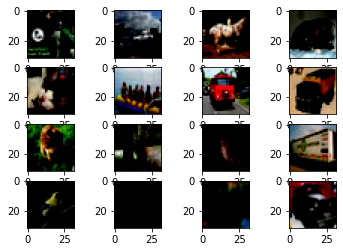

In [4]:
import matplotlib.pyplot as plt

batch_size = 32

trainloader, testloader = load_cifar10()

s = iter(trainloader)

im, la = s.next()

for i in range(16):
  plt.subplot(4, 4, i + 1)
  plt.imshow(im[i].permute(1, 2, 0).numpy())

# Augmentation and helper functions

In [ ]:

################################# AUGMENTATION #####################################


def augment(inputs, augment_mode = 'gaussian_noise'):

    if augment_mode == 'gaussian_noise':
      mean, std = 0, 0.1 # This is enough
      aug_inputs = inputs + torch.randn(inputs.size()).to('cuda') * std + mean

    elif augment_mode == 'gray_to_rgb': # create 3 channel Grayscale image
      aug_inputs = functional.rgb_to_grayscale(inputs, num_output_channels=num_channels)

    elif augment_mode == 'jigsaw':
      # create sliding blocks:
      windows = inputs.unfold(2, patch_size, step).unfold(3, patch_size, step).permute(0, 1, 4, 5, 2, 3)
      # reshape to (Batch_size, n_channels, patch_size, patch_size, grid_size, grid_size)
      windows = windows.reshape(batch_size, n_channels, patch_size, patch_size, grid_size*2,)
      # Shuffle block orderings
      windows = windows[:, :, :, :, torch.randperm(windows.size()[-1])]
      # glue back together
      windows = windows.reshape(batch_size, n_channels * patch_size* patch_size,  grid_size* grid_size)
      fold = nn.Fold(output_size=(32, 32), kernel_size=(16, 16), stride=16)
      aug_inputs = fold(windows)

    return aug_inputs


################################ HELPER METHODS ####################################

#___________VISUALIZATION_____________________

def visualize(outputs):

    # Visualize results
    min_max_scaler = preprocessing.MinMaxScaler()
    recon = min_max_scaler.fit_transform(outputs[2].permute(0, 2, 3, 1).detach().cpu().numpy().reshape((32,-1))).reshape((32, 32, 32, 3))
    aug_input = min_max_scaler.fit_transform(outputs[1].permute(0, 2, 3, 1).detach().cpu().numpy().reshape((32,-1))).reshape((32, 32, 32, 3))
    orig_input = min_max_scaler.fit_transform(outputs[0].permute(0, 2, 3, 1).detach().cpu().numpy().reshape((32,-1))).reshape((32, 32, 32, 3))
    plt.figure(figsize=(5,3)) 
    for i in range(2):
        plt.subplot(2, 3, i*3+1)
        plt.imshow(recon[i])
        plt.title('recon')
        plt.axis('off')
        plt.subplot(2, 3, i*3+2)
        plt.imshow(aug_input[i])
        plt.title('aug_in')
        plt.axis('off')
        plt.subplot(2, 3, i*3+3)
        plt.imshow(orig_input[i])
        plt.title('orig_in')
        plt.axis('off')
    plt.show()

#_________load_model_from_checkpoint____________

def load_from_checkpoint(net, checkpoint_dir):
    try:
      # Load checkpoint.
      print('==> Resuming from checkpoint..')
      checkpoint = torch.load(checkpoint_dir + 'ckpt.pth')
      net.load_state_dict(checkpoint['net'])
      loss = checkpoint['loss']
      start_epoch = checkpoint['epoch']
        
      print('current loss and epoch:')
      print(loss)
      print(start_epoch)

    except:
      a = input('no checkpoint detected... start from beginning? (y/n)')
      if a == 'n':
        exit()
    
    return net, start_epoch

#_____________Save_checkpoint__________________

def save_checkpoint(net, loss, epoch, checkpoint_dir):

    print('Saving..')
    state = {
        'net': net.state_dict(),
        'loss': loss,
        'epoch': epoch,
    }
    if not os.path.isdir(checkpoint_dir):
        os.mkdir(checkpoint_dir)
    torch.save(state, checkpoint_dir + 'ckpt.pth')

# Training functions

functions for self-supervised and supervised training

In [9]:


######################## Train AutoEncoder (Self-Supervised) ##############################


def selfsupervised_training(resume = 0, augment_mode = 'gaussian_noise'):
    
    num_channels = 3
    lr = 0.0001
    linear_classifier = False

    #_____________Load model_________________#

    if augment_mode == 'gaussian_noise':
      checkpoint_dir = '/content/drive/MyDrive/ADL/3_4/checkpoint_gaussian/'
    elif augment_mode == 'gray_to_rgb':
      checkpoint_dir = '/content/drive/MyDrive/ADL/3_4/checkpoint_grayscale/'
    elif augment_mode == 'jigsaw':
      checkpoint_dir = '/content/drive/MyDrive/ADL/3_4/checkpoint_jigsaw/'

    net = Autoencoder(linear_classifier, num_channels)
    net = net.to('cuda')

    start_epoch = 0
    loss = 0

    # Load from checkpoint
    if resume == 1:
      net, start_epoch = load_from_checkpoint(net)
      start_epoch += 1

    # Loss & optimizer
    criterion = nn.MSELoss() # mean square error loss
    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
      
    outputs = []

    #_________ Training Pipeline _____________#

    for epoch in range(start_epoch, 20):

      print('\nEpoch: %d' % epoch)
      net.train()

      train_loss = 0
      correct = 0
      total = 0

      # Train
      for batch_idx, (inputs, targets) in enumerate(tqdm(trainloader)):

          inputs = inputs.cuda()
          targets = targets.cuda()

          # Augment function

          aug_inputs = augment(inputs, augment_mode)

          optimizer.zero_grad()

          recon = net(aug_inputs)

          loss = criterion(recon, inputs)
          loss.backward()
          optimizer.step()

      print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
      outputs = (inputs, aug_inputs, recon)

      # Visualize outputs function 
      visualize(outputs)

      # Save model state
      save_checkpoint(net, loss.detach().cpu().numpy(), epoch, checkpoint_dir)




######################## Train AutoEncoder (Self-Supervised) ##############################


def supervised_training(augment_mode = 'gaussian_noise', finetuned = 'no'):
  
  num_channels = 3

  if augment_mode == 'gaussian_noise':
    checkpoint_dir = '/content/drive/MyDrive/ADL/3_4/checkpoint_gaussian/'
  elif augment_mode == 'gray_to_rgb':
    checkpoint_dir = '/content/drive/MyDrive/ADL/3_4/checkpoint_grayscale/'
  elif augment_mode == 'jigsaw':
    checkpoint_dir = '/content/drive/MyDrive/ADL/3_4/checkpoint_jigsaw/'

  # ________________________________Which model?___________________________________ #

  #_____________ Simple linear classifier

  if finetuned == 'no':
      linear_classifier = True
      net = Autoencoder(linear_classifier, num_channels)
      # Load weights from checkpoint
      net, _ = load_from_checkpoint(net, checkpoint_dir)

  #_____________ Pretrained VGG16 classification

  elif finetuned == 'vgg16':
      net = models.vgg16(pretrained = True)
      net.classifier = nn.Linear(25088, 10)

  #_____________ Pretrained ResNet18 Classification

  elif finetuned == 'resnet18':
      net = models.resnet18(pretrained = True)
      net.fc = nn.Linear(512, 10)

  #_____________ Use decoder's output as input to pretrained VGG16 or ResNet18 Classifier!

  elif (finetuned == 'resnet18_decoder') or (finetuned == 'vgg16_decoder'):
      linear_classifier = False
      autoencoder = Autoencoder(linear_classifier, num_channels)
      # Load autoencoder weights from checkpoint
      autoencoder, _ = load_from_checkpoint(autoencoder, checkpoint_dir)
      # freeze autoencoder
      for _, param in autoencoder.named_parameters():
            param.requires_grad = False
      autoencoder = autoencoder.to('cuda')

      if finetuned == 'vgg16_decoder': 
          net = models.vgg16(pretrained = True)
          net.classifier = nn.Linear(25088, 10)
      elif finetuned == 'resnet18_decoder':
          net = models.resnet18(pretrained = True)
          net.fc = nn.Linear(512, 10)

  net = net.to('cuda')

  # freeze all classifier layers but the last fc
  for name, param in net.named_parameters():
      if ('linear' not in name) and ('classifier' not in name) and ('fc' not in name): 
          param.requires_grad = False
      else:
          param.requires_grad = True

  start_epoch = 0
  loss = 0

  # Loss & optimizer
  criterion = nn.CrossEntropyLoss() # mean square error loss
  optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

  #_____________________ Training Pipeline ______________________#

  for epoch in range(start_epoch, 20):

    print('\nEpoch: %d' % epoch)
    net.train()

    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(trainloader):

        inputs = inputs.cuda()
        targets = targets.cuda()

        optimizer.zero_grad()

        if (finetuned == 'resnet18_decoder') or (finetuned == 'vgg16_decoder'):
            decoded = autoencoder(inputs) 
            decoded = decoded.detach() # Treat this as input image to classifier model
            logits  =  net(decoded) 

        else:
            logits = net(inputs) 

        loss = criterion(logits, targets)
        loss.backward()
        optimizer.step()

        _, predicted = logits.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    train_accuracy = 100.*correct/total
    test_accuracy = 0
    correct = 0
    total = 0

    # ____________________Test phase_________________________#

    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs = inputs.to('cuda')
        targets = targets.to('cuda')

        if (finetuned == 'resnet18_decoder') or (finetuned == 'vgg16_decoder'):
            decoded = autoencoder(inputs) 
            decoded = decoded.detach() # Treat this as input image to classifier model
            logits  =  net(decoded) 

        else:
            logits = net(inputs) 

        _, predicted = logits.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    test_accuracy = 100.*correct/total

    print(f"Epoch {epoch}\t Train accuracy {train_accuracy}\t Test accuracy: {test_accuracy}")

# Finetuning VGG16 and ResNet18

Normal Cifar10 classification using VGG16 and ResNet.

This has nothing to do with our Autoencoder model and self-supervision

VGG16	 Test accuracy: 88.85216346153847

ResNet18	 Test accuracy: 81.79086538461539

ResNet18 is worse because we are using output of stage 4

In [44]:
supervised_training(finetuned='vgg16')


Epoch: 0
Epoch 0	 Train accuracy 79.20334507042253	 Test accuracy: 85.59695512820512

Epoch: 1
Epoch 1	 Train accuracy 88.74239756722152	 Test accuracy: 87.38982371794872

Epoch: 2
Epoch 2	 Train accuracy 92.33154609475032	 Test accuracy: 88.1610576923077

Epoch: 3
Epoch 3	 Train accuracy 94.4822343149808	 Test accuracy: 88.78205128205128

Epoch: 4
Epoch 4	 Train accuracy 95.91269206145967	 Test accuracy: 86.52844551282051

Epoch: 5
Epoch 5	 Train accuracy 96.57890524967989	 Test accuracy: 87.8505608974359

Epoch: 6
Epoch 6	 Train accuracy 97.10907490396927	 Test accuracy: 88.41145833333333

Epoch: 7
Epoch 7	 Train accuracy 97.39316581306018	 Test accuracy: 88.85216346153847

Epoch: 8
Epoch 8	 Train accuracy 97.79729513444302	 Test accuracy: 88.26121794871794

Epoch: 9
Epoch 9	 Train accuracy 97.86131562099872	 Test accuracy: 88.25120192307692

Epoch: 10
Epoch 10	 Train accuracy 98.06338028169014	 Test accuracy: 87.95072115384616

Epoch: 11
Epoch 11	 Train accuracy 98.13140204865557	 

In [8]:
supervised_training(finetuned='resnet18')

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth




Epoch: 0
Epoch 0	 Train accuracy 65.74503841229193	 Test accuracy: 73.64783653846153

Epoch: 1
Epoch 1	 Train accuracy 78.66117157490397	 Test accuracy: 76.98317307692308

Epoch: 2
Epoch 2	 Train accuracy 83.65076824583866	 Test accuracy: 78.71594551282051

Epoch: 3
Epoch 3	 Train accuracy 87.12788092189501	 Test accuracy: 79.65745192307692

Epoch: 4
Epoch 4	 Train accuracy 89.96478873239437	 Test accuracy: 80.21834935897436

Epoch: 5
Epoch 5	 Train accuracy 92.35155249679897	 Test accuracy: 80.43870192307692

Epoch: 6
Epoch 6	 Train accuracy 93.60995518565942	 Test accuracy: 80.36858974358974

Epoch: 7
Epoch 7	 Train accuracy 94.89636683738796	 Test accuracy: 81.05969551282051

Epoch: 8
Epoch 8	 Train accuracy 95.37852112676056	 Test accuracy: 81.1298076923077

Epoch: 9
Epoch 9	 Train accuracy 96.08874839948784	 Test accuracy: 81.03966346153847

Epoch: 10
Epoch 10	 Train accuracy 96.46887003841229	 Test accuracy: 80.7391826923077

Epoch: 11
Epoch 11	 Train accuracy 96.88900448143406

# 1: Gaussian denoising

## Train self-supervised

10 epochs

  0%|          | 0/1562 [00:00<?, ?it/s]


Epoch: 0


100%|██████████| 1562/1562 [01:08<00:00, 22.83it/s]


Epoch:1, Loss:0.2047


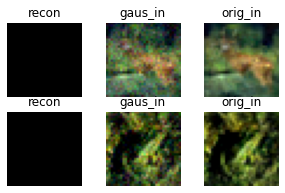

Saving..

Epoch: 1

  0%|          | 0/1562 [00:00<?, ?it/s]

100%|██████████| 1562/1562 [01:08<00:00, 22.80it/s]


Epoch:2, Loss:0.1675


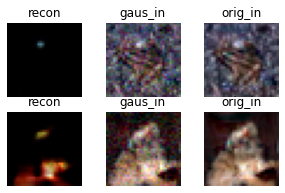

Saving..


  0%|          | 0/1562 [00:00<?, ?it/s]


Epoch: 2


100%|██████████| 1562/1562 [01:08<00:00, 22.73it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:3, Loss:0.1637


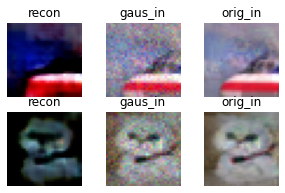

Saving..


  0%|          | 0/1562 [00:00<?, ?it/s]


Epoch: 3


100%|██████████| 1562/1562 [01:08<00:00, 22.76it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:4, Loss:0.1221


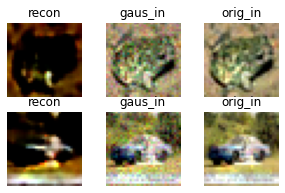

  0%|          | 0/1562 [00:00<?, ?it/s]

Saving..

Epoch: 4


100%|██████████| 1562/1562 [01:08<00:00, 22.76it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:5, Loss:0.1579


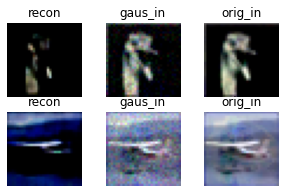

Saving..


  0%|          | 0/1562 [00:00<?, ?it/s]


Epoch: 5


100%|██████████| 1562/1562 [01:08<00:00, 22.76it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:6, Loss:0.1614


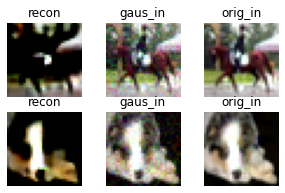

Saving..


  0%|          | 0/1562 [00:00<?, ?it/s]


Epoch: 6


100%|██████████| 1562/1562 [01:08<00:00, 22.77it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:7, Loss:0.1690


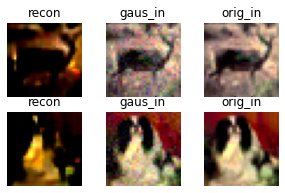

Saving..


  0%|          | 0/1562 [00:00<?, ?it/s]


Epoch: 7


100%|██████████| 1562/1562 [01:08<00:00, 22.78it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:8, Loss:0.1683


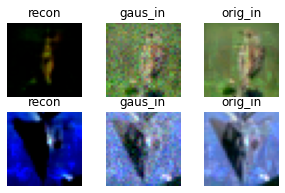

Saving..


  0%|          | 0/1562 [00:00<?, ?it/s]


Epoch: 8


100%|██████████| 1562/1562 [01:08<00:00, 22.81it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:9, Loss:0.1515


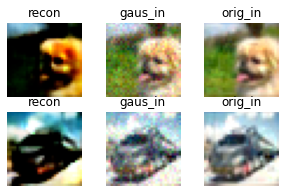

  0%|          | 0/1562 [00:00<?, ?it/s]

Saving..

Epoch: 9


100%|██████████| 1562/1562 [01:08<00:00, 22.84it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:10, Loss:0.1435


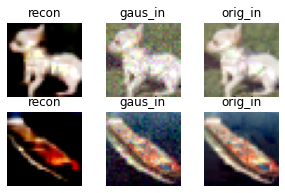

Saving..


  0%|          | 0/1562 [00:00<?, ?it/s]


Epoch: 10


100%|██████████| 1562/1562 [01:08<00:00, 22.86it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:11, Loss:0.1251


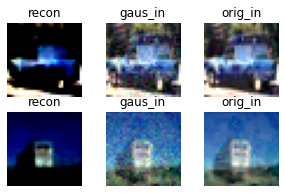

Saving..


  0%|          | 0/1562 [00:00<?, ?it/s]


Epoch: 11


 23%|██▎       | 361/1562 [00:15<00:52, 22.90it/s]

In [ ]:
selfsupervised_training(resume = 0) 

## Train supervised (linear)

20 epochs

Train accuracy 42.401568501920615	 Test accuracy: 42.87860576923077

In [ ]:
supervised_training()

  0%|          | 0/1562 [00:00<?, ?it/s]

==> Resuming from checkpoint..
current loss and epoch:
0.1251118
10

Epoch: 0


  0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 0	 Train accuracy 25.844270166453263	 Test accuracy: 31.720753205128204

Epoch: 1


  0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 1	 Train accuracy 33.15661011523687	 Test accuracy: 34.79567307692308

Epoch: 2


  0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 2	 Train accuracy 35.32130281690141	 Test accuracy: 36.408253205128204

Epoch: 3


  0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 3	 Train accuracy 36.5937099871959	 Test accuracy: 36.90905448717949

Epoch: 4


  0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 4	 Train accuracy 37.419974391805376	 Test accuracy: 37.98076923076923

Epoch: 5


  0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 5	 Train accuracy 38.170214468629965	 Test accuracy: 38.74198717948718

Epoch: 6


  0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 6	 Train accuracy 38.982474391805376	 Test accuracy: 38.92227564102564

Epoch: 7


  0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 7	 Train accuracy 39.522647247119075	 Test accuracy: 39.23277243589744

Epoch: 8


  0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 8	 Train accuracy 40.04081306017926	 Test accuracy: 40.00400641025641

Epoch: 9


  0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 9	 Train accuracy 40.23687580025608	 Test accuracy: 40.30448717948718

Epoch: 10


  0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 10	 Train accuracy 40.46094750320103	 Test accuracy: 40.79527243589744

Epoch: 11


  0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 11	 Train accuracy 40.957106274007685	 Test accuracy: 41.08573717948718

Epoch: 12


  0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 12	 Train accuracy 41.31322023047375	 Test accuracy: 41.26602564102564

Epoch: 13


  0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 13	 Train accuracy 41.34122919334187	 Test accuracy: 41.55649038461539

Epoch: 14


  0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 14	 Train accuracy 41.64332586427657	 Test accuracy: 41.94711538461539

Epoch: 15


  0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 15	 Train accuracy 41.66733354673495	 Test accuracy: 41.78685897435897

Epoch: 16


  0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 16	 Train accuracy 42.203505121638926	 Test accuracy: 42.317708333333336

Epoch: 17


  0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 17	 Train accuracy 42.199503841229195	 Test accuracy: 42.42788461538461

Epoch: 18


  0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 18	 Train accuracy 42.15749039692702	 Test accuracy: 42.42788461538461

Epoch: 19


100%|██████████| 1562/1562 [00:15<00:00, 102.16it/s]


Epoch 19	 Train accuracy 42.401568501920615	 Test accuracy: 42.87860576923077


## Train supervised (ResNet18 finetuning)

In this mode, Autoencoder's decoder is used as input image for ResNet18 Pretrained model.

Autoencoder's layers are frozen and decoder's output is detached from the graph. ResNet18's layers but the last FC are frozen.

Worse because we are using stage 4 which does not provide a good representation for our data

Train accuracy 35.881482074263765	 Test accuracy: 35.40665064102564

In [10]:
supervised_training(finetuned='resnet18_decoder')

==> Resuming from checkpoint..
current loss and epoch:
0.1251118
10

Epoch: 0
Epoch 0	 Train accuracy 21.73095390524968	 Test accuracy: 28.40544871794872

Epoch: 1
Epoch 1	 Train accuracy 30.00360115236876	 Test accuracy: 31.46033653846154

Epoch: 2
Epoch 2	 Train accuracy 32.41237195902689	 Test accuracy: 32.48197115384615

Epoch: 3
Epoch 3	 Train accuracy 33.02056658130602	 Test accuracy: 33.25320512820513

Epoch: 4
Epoch 4	 Train accuracy 34.26496478873239	 Test accuracy: 33.57371794871795

Epoch: 5
Epoch 5	 Train accuracy 34.08290653008963	 Test accuracy: 34.22475961538461

Epoch: 6
Epoch 6	 Train accuracy 34.342989756722154	 Test accuracy: 34.36498397435897

Epoch: 7
Epoch 7	 Train accuracy 35.19526248399488	 Test accuracy: 34.52524038461539

Epoch: 8
Epoch 8	 Train accuracy 35.21927016645326	 Test accuracy: 34.865785256410255

Epoch: 9
Epoch 9	 Train accuracy 35.19526248399488	 Test accuracy: 35.046073717948715

Epoch: 10
Epoch 10	 Train accuracy 35.327304737516	 Test accuracy: 3

## Supervised training (VGG16 finetuning)

Just like the way we treated ResNet18 finetuning but on VGG16

Train accuracy 44.13812419974392	 Test accuracy: 43.860176282051285

Better! :)

In [11]:
supervised_training(finetuned='vgg16_decoder')

==> Resuming from checkpoint..
current loss and epoch:
0.1251118
10


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth




Epoch: 0
Epoch 0	 Train accuracy 41.71935019206146	 Test accuracy: 43.249198717948715

Epoch: 1
Epoch 1	 Train accuracy 43.74799935979514	 Test accuracy: 44.00040064102564

Epoch: 2
Epoch 2	 Train accuracy 44.098111395646605	 Test accuracy: 41.61658653846154

Epoch: 3
Epoch 3	 Train accuracy 44.28817221510884	 Test accuracy: 42.58814102564103

Epoch: 4
Epoch 4	 Train accuracy 44.04209346991037	 Test accuracy: 43.69991987179487

Epoch: 5
Epoch 5	 Train accuracy 44.05009603072983	 Test accuracy: 42.71834935897436

Epoch: 6
Epoch 6	 Train accuracy 44.146126760563384	 Test accuracy: 42.81850961538461

Epoch: 7
Epoch 7	 Train accuracy 43.95006402048656	 Test accuracy: 43.68990384615385

Epoch: 8
Epoch 8	 Train accuracy 44.13812419974392	 Test accuracy: 43.860176282051285

Epoch: 9
Epoch 9	 Train accuracy 43.986075544174135	 Test accuracy: 43.11899038461539

Epoch: 10
Epoch 10	 Train accuracy 44.190140845070424	 Test accuracy: 42.77844551282051

Epoch: 11
Epoch 11	 Train accuracy 44.096110

# 2: Grayscale to RGB

## Train self-supervised

10 epochs

MSE has hard time reconstructing colors

  0%|          | 0/1562 [00:00<?, ?it/s]


Epoch: 0


100%|██████████| 1562/1562 [01:57<00:00, 13.26it/s]


Epoch:1, Loss:0.2029


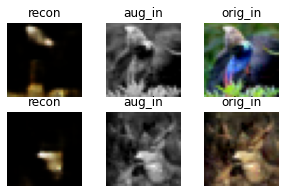

Saving..


  0%|          | 0/1562 [00:00<?, ?it/s]


Epoch: 1


100%|██████████| 1562/1562 [01:57<00:00, 13.29it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:2, Loss:0.2040


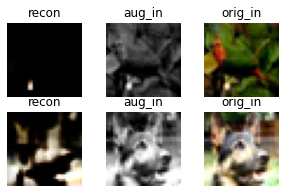

  0%|          | 0/1562 [00:00<?, ?it/s]

Saving..

Epoch: 2


100%|██████████| 1562/1562 [01:57<00:00, 13.33it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:3, Loss:0.1433


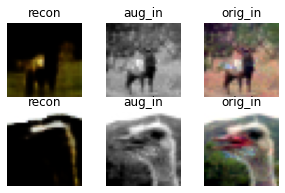

  0%|          | 0/1562 [00:00<?, ?it/s]

Saving..

Epoch: 3


100%|██████████| 1562/1562 [01:57<00:00, 13.34it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:4, Loss:0.1517


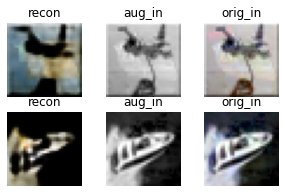

  0%|          | 0/1562 [00:00<?, ?it/s]

Saving..

Epoch: 4


100%|██████████| 1562/1562 [01:57<00:00, 13.33it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:5, Loss:0.1325


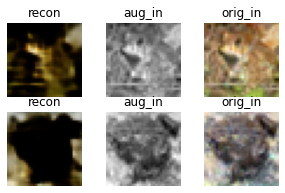

  0%|          | 0/1562 [00:00<?, ?it/s]

Saving..

Epoch: 5


100%|██████████| 1562/1562 [01:57<00:00, 13.33it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:6, Loss:0.1462


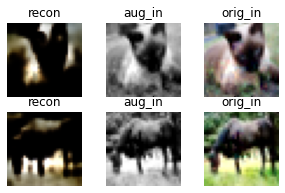

  0%|          | 0/1562 [00:00<?, ?it/s]

Saving..

Epoch: 6


100%|██████████| 1562/1562 [01:57<00:00, 13.33it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:7, Loss:0.1596


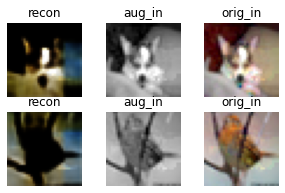

  0%|          | 0/1562 [00:00<?, ?it/s]

Saving..

Epoch: 7


100%|██████████| 1562/1562 [01:57<00:00, 13.32it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:8, Loss:0.1651


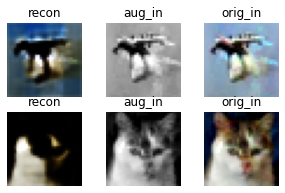

  0%|          | 0/1562 [00:00<?, ?it/s]

Saving..

Epoch: 8


100%|██████████| 1562/1562 [01:57<00:00, 13.31it/s]


Epoch:9, Loss:0.1551


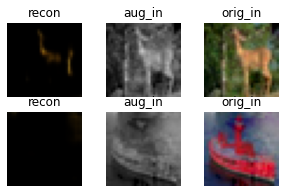

  0%|          | 0/1562 [00:00<?, ?it/s]

Saving..

Epoch: 9


100%|██████████| 1562/1562 [01:57<00:00, 13.27it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:10, Loss:0.1501


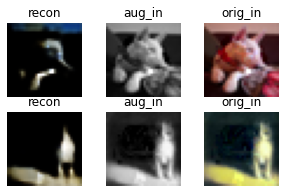

  0%|          | 0/1562 [00:00<?, ?it/s]

Saving..

Epoch: 10


 10%|█         | 161/1562 [00:12<01:45, 13.28it/s]

KeyboardInterrupt: ignored

In [ ]:
selfsupervised_training(resume = 0, augment_mode = 'gray_to_rgb') 

## Train supervised (linear)

Train accuracy 32.09627080665813	 Test accuracy: 32.72235576923077

In [ ]:
supervised_training(augment_mode = 'gray_to_rgb')

==> Resuming from checkpoint..
current loss and epoch:
0.15007192
9

Epoch: 0
Epoch 0	 Train accuracy 18.651968629961587	 Test accuracy: 24.76963141025641

Epoch: 1
Epoch 1	 Train accuracy 25.32410371318822	 Test accuracy: 27.073317307692307

Epoch: 2
Epoch 2	 Train accuracy 26.910611395646608	 Test accuracy: 27.84455128205128

Epoch: 3
Epoch 3	 Train accuracy 27.70286491677337	 Test accuracy: 28.79607371794872

Epoch: 4
Epoch 4	 Train accuracy 28.663172215108833	 Test accuracy: 29.236778846153847

Epoch: 5
Epoch 5	 Train accuracy 29.17933738796415	 Test accuracy: 29.45713141025641

Epoch: 6
Epoch 6	 Train accuracy 29.735515364916772	 Test accuracy: 30.208333333333332

Epoch: 7
Epoch 7	 Train accuracy 30.009603072983353	 Test accuracy: 30.348557692307693

Epoch: 8
Epoch 8	 Train accuracy 30.391725352112676	 Test accuracy: 30.719150641025642

Epoch: 9
Epoch 9	 Train accuracy 30.535771446862995	 Test accuracy: 31.199919871794872

Epoch: 10
Epoch 10	 Train accuracy 31.05993918053777	 Test

## Train supervised (ResNet18 finetuning)

Train accuracy 32.09627080665813	 Test accuracy: 32.72235576923077

In [13]:
supervised_training(augment_mode = 'gray_to_rgb', finetuned='resnet18_decoder')

==> Resuming from checkpoint..
current loss and epoch:
0.15007192
9

Epoch: 0
Epoch 0	 Train accuracy 19.720310499359794	 Test accuracy: 24.749599358974358

Epoch: 1
Epoch 1	 Train accuracy 26.408450704225352	 Test accuracy: 27.784455128205128

Epoch: 2
Epoch 2	 Train accuracy 28.155009603072983	 Test accuracy: 28.485576923076923

Epoch: 3
Epoch 3	 Train accuracy 29.425416133162614	 Test accuracy: 29.40705128205128

Epoch: 4
Epoch 4	 Train accuracy 29.75552176696543	 Test accuracy: 29.927884615384617

Epoch: 5
Epoch 5	 Train accuracy 30.339708706786173	 Test accuracy: 30.298477564102566

Epoch: 6
Epoch 6	 Train accuracy 30.539772727272727	 Test accuracy: 30.64903846153846

Epoch: 7
Epoch 7	 Train accuracy 30.87187900128041	 Test accuracy: 30.799278846153847

Epoch: 8
Epoch 8	 Train accuracy 30.815861075544174	 Test accuracy: 30.458733974358974

Epoch: 9
Epoch 9	 Train accuracy 31.115957106274006	 Test accuracy: 30.859375

Epoch: 10
Epoch 10	 Train accuracy 31.26800576184379	 Test accur

## Train supervised (VGG16 finetuning)

Train accuracy 38.554337387964146	 Test accuracy: 37.98076923076923

In [14]:
supervised_training(augment_mode = 'gray_to_rgb', finetuned='vgg16_decoder')

==> Resuming from checkpoint..
current loss and epoch:
0.15007192
9

Epoch: 0
Epoch 0	 Train accuracy 36.4776728553137	 Test accuracy: 37.52003205128205

Epoch: 1
Epoch 1	 Train accuracy 38.21622919334187	 Test accuracy: 38.69190705128205

Epoch: 2
Epoch 2	 Train accuracy 38.776408450704224	 Test accuracy: 37.67027243589744

Epoch: 3
Epoch 3	 Train accuracy 38.416293213828425	 Test accuracy: 37.27964743589744

Epoch: 4
Epoch 4	 Train accuracy 38.84042893725992	 Test accuracy: 37.64022435897436

Epoch: 5
Epoch 5	 Train accuracy 38.78641165172856	 Test accuracy: 37.69030448717949

Epoch: 6
Epoch 6	 Train accuracy 38.67237516005122	 Test accuracy: 37.630208333333336

Epoch: 7
Epoch 7	 Train accuracy 38.620358514724714	 Test accuracy: 37.760416666666664

Epoch: 8
Epoch 8	 Train accuracy 38.97447183098591	 Test accuracy: 38.000801282051285

Epoch: 9
Epoch 9	 Train accuracy 38.894446222791295	 Test accuracy: 36.6786858974359

Epoch: 10
Epoch 10	 Train accuracy 38.58234635083227	 Test accurac

# 3: Jigsaw Puzzle (4 patches)

## Train self-supervised

10 epochs

  0%|          | 0/1562 [00:00<?, ?it/s]


Epoch: 0


100%|██████████| 1562/1562 [01:07<00:00, 23.17it/s]


Epoch:1, Loss:0.2577


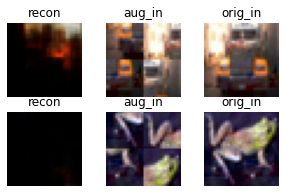

Saving..


  0%|          | 0/1562 [00:00<?, ?it/s]


Epoch: 1


100%|██████████| 1562/1562 [01:07<00:00, 23.04it/s]


Epoch:2, Loss:0.2116


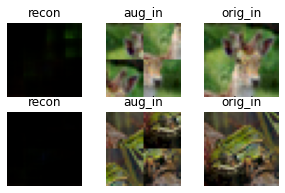

Saving..


  0%|          | 0/1562 [00:00<?, ?it/s]


Epoch: 2


100%|██████████| 1562/1562 [01:07<00:00, 23.06it/s]


Epoch:3, Loss:0.2174


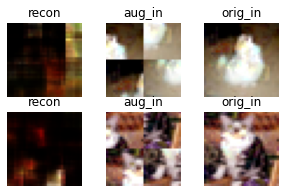

Saving..


  0%|          | 0/1562 [00:00<?, ?it/s]


Epoch: 3


100%|██████████| 1562/1562 [01:07<00:00, 23.12it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:4, Loss:0.1917


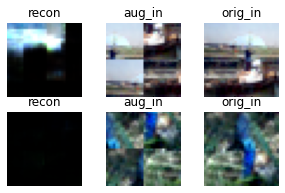

Saving..


  0%|          | 0/1562 [00:00<?, ?it/s]


Epoch: 4


100%|██████████| 1562/1562 [01:07<00:00, 23.10it/s]


Epoch:5, Loss:0.1845


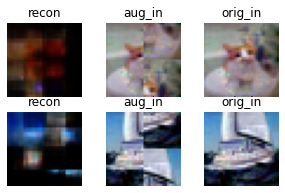

Saving..


  0%|          | 0/1562 [00:00<?, ?it/s]


Epoch: 5


100%|██████████| 1562/1562 [01:07<00:00, 23.14it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:6, Loss:0.1805


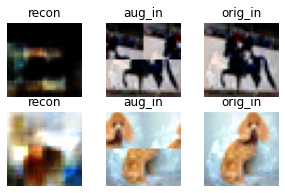

  0%|          | 0/1562 [00:00<?, ?it/s]

Saving..

Epoch: 6


100%|██████████| 1562/1562 [01:07<00:00, 23.21it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:7, Loss:0.2194


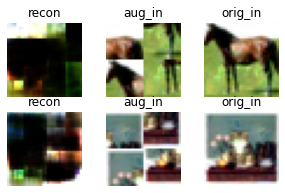

Saving..


  0%|          | 0/1562 [00:00<?, ?it/s]


Epoch: 7


100%|██████████| 1562/1562 [01:07<00:00, 23.23it/s]


Epoch:8, Loss:0.2249


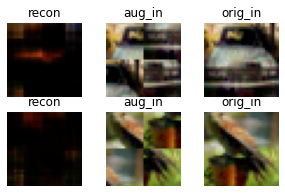

Saving..


  0%|          | 0/1562 [00:00<?, ?it/s]


Epoch: 8


100%|██████████| 1562/1562 [01:07<00:00, 23.22it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:9, Loss:0.1965


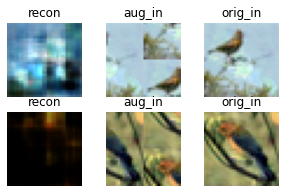

Saving..


  0%|          | 0/1562 [00:00<?, ?it/s]


Epoch: 9


100%|██████████| 1562/1562 [01:07<00:00, 23.22it/s]


Epoch:10, Loss:0.2194


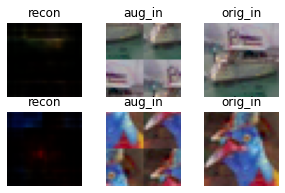

Saving..


  0%|          | 0/1562 [00:00<?, ?it/s]


Epoch: 10


100%|██████████| 1562/1562 [01:07<00:00, 23.19it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:11, Loss:0.2028


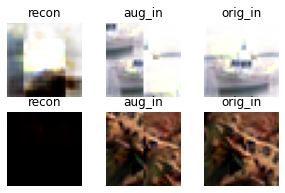

Saving..


  0%|          | 0/1562 [00:00<?, ?it/s]


Epoch: 11


 22%|██▏       | 337/1562 [00:14<00:52, 23.20it/s]

In [ ]:
selfsupervised_training(resume = 0, augment_mode = 'jigsaw') 

## Train supervised (linear)

Train accuracy 40.66101152368758	 Test accuracy: 41.38621794871795

In [ ]:
supervised_training(augment_mode = 'jigsaw')

==> Resuming from checkpoint..
current loss and epoch:
0.20279735
10

Epoch: 0
Epoch 0	 Train accuracy 22.911331626120358	 Test accuracy: 31.22996794871795

Epoch: 1
Epoch 1	 Train accuracy 32.328345070422536	 Test accuracy: 33.41346153846154

Epoch: 2
Epoch 2	 Train accuracy 33.914852752880925	 Test accuracy: 34.49519230769231

Epoch: 3
Epoch 3	 Train accuracy 34.50504161331626	 Test accuracy: 35.40665064102564

Epoch: 4
Epoch 4	 Train accuracy 35.291293213828425	 Test accuracy: 36.33814102564103

Epoch: 5
Epoch 5	 Train accuracy 36.16557298335467	 Test accuracy: 36.798878205128204

Epoch: 6
Epoch 6	 Train accuracy 36.59170934699104	 Test accuracy: 37.27964743589744

Epoch: 7
Epoch 7	 Train accuracy 37.167893725992315	 Test accuracy: 38.000801282051285

Epoch: 8
Epoch 8	 Train accuracy 37.489996798975675	 Test accuracy: 38.43149038461539

Epoch: 9
Epoch 9	 Train accuracy 38.096190781049934	 Test accuracy: 38.91225961538461

Epoch: 10
Epoch 10	 Train accuracy 38.32426376440461	 Test ac

## Train supervised (ResNet18 finetuning)

Train accuracy 29.5654609475032	 Test accuracy: 28.645833333333332

In [15]:
supervised_training(augment_mode = 'jigsaw', finetuned='resnet18_decoder')

==> Resuming from checkpoint..
current loss and epoch:
0.20279735
10

Epoch: 0
Epoch 0	 Train accuracy 19.650288092189502	 Test accuracy: 23.387419871794872

Epoch: 1
Epoch 1	 Train accuracy 25.176056338028168	 Test accuracy: 25.530849358974358

Epoch: 2
Epoch 2	 Train accuracy 26.612516005121638	 Test accuracy: 26.903044871794872

Epoch: 3
Epoch 3	 Train accuracy 27.360755441741357	 Test accuracy: 27.173477564102566

Epoch: 4
Epoch 4	 Train accuracy 28.30905889884763	 Test accuracy: 27.75440705128205

Epoch: 5
Epoch 5	 Train accuracy 28.29305377720871	 Test accuracy: 27.27363782051282

Epoch: 6
Epoch 6	 Train accuracy 28.487115877080665	 Test accuracy: 27.734375

Epoch: 7
Epoch 7	 Train accuracy 28.79521446862996	 Test accuracy: 28.094951923076923

Epoch: 8
Epoch 8	 Train accuracy 28.90725032010243	 Test accuracy: 28.23517628205128

Epoch: 9
Epoch 9	 Train accuracy 29.36339628681178	 Test accuracy: 28.175080128205128

Epoch: 10
Epoch 10	 Train accuracy 29.40340909090909	 Test accuracy

## Train supervised (VGG16 finetuning)

Train accuracy 33.206626120358514	 Test accuracy: 33.283253205128204

In [16]:
supervised_training(augment_mode = 'jigsaw', finetuned='vgg16_decoder')

==> Resuming from checkpoint..
current loss and epoch:
0.20279735
10

Epoch: 0
Epoch 0	 Train accuracy 31.187980153649168	 Test accuracy: 32.21153846153846

Epoch: 1
Epoch 1	 Train accuracy 32.64044494238156	 Test accuracy: 31.280048076923077

Epoch: 2
Epoch 2	 Train accuracy 32.78849231754161	 Test accuracy: 31.450320512820515

Epoch: 3
Epoch 3	 Train accuracy 33.12860115236876	 Test accuracy: 33.06290064102564

Epoch: 4
Epoch 4	 Train accuracy 32.97255121638924	 Test accuracy: 32.49198717948718

Epoch: 5
Epoch 5	 Train accuracy 33.11259603072983	 Test accuracy: 33.34334935897436

Epoch: 6
Epoch 6	 Train accuracy 32.75248079385403	 Test accuracy: 32.75240384615385

Epoch: 7
Epoch 7	 Train accuracy 32.92253521126761	 Test accuracy: 31.470352564102566

Epoch: 8
Epoch 8	 Train accuracy 33.048575544174135	 Test accuracy: 33.00280448717949

Epoch: 9
Epoch 9	 Train accuracy 32.90052816901409	 Test accuracy: 31.22996794871795

Epoch: 10
Epoch 10	 Train accuracy 33.04257362355954	 Test accura